<a href="https://colab.research.google.com/github/tanvirtaher32/Sarcasm-Detection/blob/main/SVM_with_emoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=c4213945f99e922bb79c3043dba5d4d78627caa66ea7ee57366de296448397e1
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
data = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset_v3.json", lines=True)

# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

# Extract emojis from text
def extract_emojis(text):
    emojis = []
    for char in text:
        if char in emoji.EMOJI_DATA['🥇']['en']:
            emojis.append(char)
    return emojis

data['clean_text'] = data['headline'].apply(clean_text)
data['emojis'] = data['clean_text'].apply(extract_emojis)

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

data['tokenized_text'] = data['clean_text'].apply(tokenize_and_remove_stopwords)

# Split the data into train and test sets
X_text = data['tokenized_text']
X_emojis = data['emojis']
y = data['is_sarcastic']

train_size = int(len(X_text) * 0.8)
X_text_train, X_text_test = X_text[:train_size], X_text[train_size:]
X_emojis_train, X_emojis_test = X_emojis[:train_size], X_emojis[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(X_text_test)

# Encode emojis as one-hot vectors
emoji_encoder = np.zeros((len(X_emojis), len(emoji.EMOJI_DATA['🥇']['en'])), dtype=int)
for i, emojis in enumerate(X_emojis):
    for emoji_char in emojis:
        emoji_index = list(emoji.EMOJI_DATA['🥇']['en']).index(emoji_char)
        emoji_encoder[i, emoji_index] = 1

X_emojis_train_vec = emoji_encoder[:train_size]
X_emojis_test_vec = emoji_encoder[train_size:]

# Combine text and emoji features
X_train = np.hstack((X_text_train_vec.toarray(), X_emojis_train_vec))
X_test = np.hstack((X_text_test_vec.toarray(), X_emojis_test_vec))

# Train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_matrix)
print('Classification Report:')
print(classification_report)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.7715
Confusion Matrix:
[[898 212]
 [245 645]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1110
           1       0.75      0.72      0.74       890

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



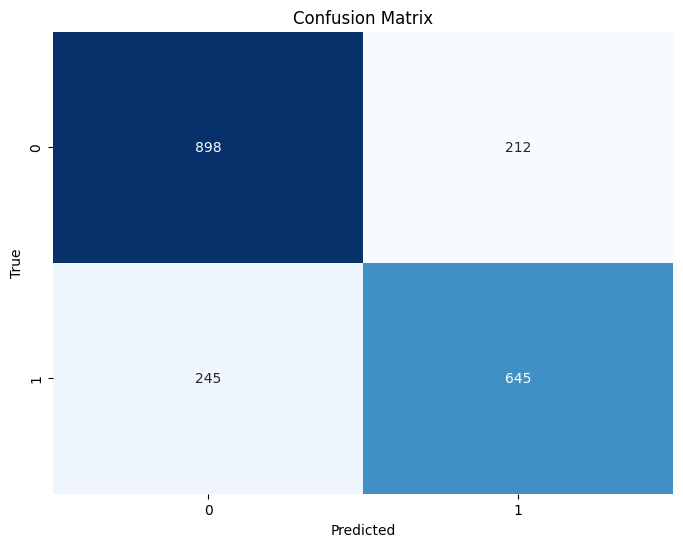

Accuracy: 0.7715
Confusion Matrix:
[[898 212]
 [245 645]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1110
           1       0.75      0.72      0.74       890

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate the plots
plot_confusion_matrix(confusion_matrix)

print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_matrix)
print('Classification Report:')
print(classification_report)